# Analysis of Panama Papers

I would like to specify that the names that come up in the below assignment do not reflect that they have broken the law, nor am I accusing them of the same. I am only using the analysis as an activity or mechanism to find possible links and connections between various entities and individuals. 

In [1]:
!pip install leidenalg
!pip install python-igraph
!pip install pputils
!pip install node2vec

     |████████████████████████████████| 2.4MB 11.3MB/s 
     |████████████████████████████████| 3.2MB 57.4MB/s 
  Created wheel for pputils: filename=pputils-1.2-cp36-none-any.whl size=1672 sha256=71e41ced85a464f91f411199d4de9ca5614655770dcc51e1683f9325bc017620
  Stored in directory: /root/.cache/pip/wheels/23/34/c7/d2fd161a81133979ece71d0e666a2cc7ec221bd2da8805d314
Successfully built pputils
  Created wheel for node2vec: filename=node2vec-0.4.1-cp36-none-any.whl size=5736 sha256=63b712ab616ab0afa7a99279eba43d135044742265f233930f6ca71d80e97910
  Stored in directory: /root/.cache/pip/wheels/b3/59/ea/22e964f74bb864c5423cf82027a4d69dd65bac0bbf95fd46f5
Successfully built node2vec


In [2]:
!unzip csv_panama_papers.2018-02-14.zip

Archive:  csv_panama_papers.2018-02-14.zip
  inflating: panama_papers.edges.csv  
  inflating: panama_papers.nodes.address.csv  
  inflating: panama_papers.nodes.entity.csv  
  inflating: panama_papers.nodes.intermediary.csv  
  inflating: panama_papers.nodes.officer.csv  


## Import Packages

In [3]:
import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [4]:
from tqdm import tqdm
from node2vec import Node2Vec

In [5]:
#from py2neo import Graph
import igraph as ig
from igraph import *
import leidenalg

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from operator import itemgetter
import community as cm

import random

%matplotlib inline
import matplotlib as mpl
mpl.style.use("ggplot")

from sklearn.model_selection import train_test_split
from pputils import *

## Load Files

Below is the code to load all the csv files and create a graph specifically for the entities that have the country code as 'France'. This is done so that the number of nodes are small and thus the analysis can be carried out with speed and efficiency. The same analysis can be done with larger sets of data such as entities in Hong Kong or China where most of the entities seem to be concentrated.

In [7]:
adds = pd.read_csv("panama_papers.nodes.address.csv", low_memory=False)
ents = pd.read_csv("panama_papers.nodes.entity.csv", low_memory=False)
inter = pd.read_csv("panama_papers.nodes.intermediary.csv", low_memory=False)
offi = pd.read_csv("panama_papers.nodes.officer.csv", low_memory=False)
edges = pd.read_csv("panama_papers.edges.csv", low_memory=False)

In [8]:
ents_FRA = ents[ents['country_codes']=='FRA']
FRA_entities = ents_FRA['node_id'].tolist()
start= edges.loc[(edges['START_ID'].isin(FRA_entities)|edges['END_ID'].isin(FRA_entities))]['START_ID'].tolist()
end = edges.loc[(edges['START_ID'].isin(FRA_entities)|edges['END_ID'].isin(FRA_entities))]['END_ID'].tolist()
ids= list(set(start+end))
offi_FRA = offi[offi['node_id'].isin(ids)]
inter_FRA = inter[inter['node_id'].isin(ids)]
adds_FRA = adds[adds['node_id'].isin(ids)]
edges_FRA = edges.loc[(edges['START_ID'].isin(FRA_entities)|edges['END_ID'].isin(FRA_entities))]

### Graph Creation for France

In [9]:

G_FRA = nx.Graph()

for n,row in adds_FRA.iterrows():
    G_FRA.add_node(row.node_id, node_type="address", details=row.to_dict())    
for n,row in ents_FRA.iterrows():
    G_FRA.add_node(row.node_id, node_type="entities", details=row.to_dict())    
for n,row in inter_FRA.iterrows():
    G_FRA.add_node(row.node_id, node_type="intermediates", details=row.to_dict())    
for n,row in offi_FRA.iterrows():
    G_FRA.add_node(row.node_id, node_type="officers", details=row.to_dict())    
for n,row in edges_FRA.iterrows():
    G_FRA.add_edge(row.START_ID, row.END_ID, rel_type=row.TYPE, details={})

## EDA


The initial EDA is performed to look at the kind of data at hand. Perhaps the most interesting thing to notice here is that for most of the datasets, the location is concentrated in Hong Kong. Most entites have defaulted or are active. The jurisdiction of the largest number of entities belongs to the British Virgin Islands.

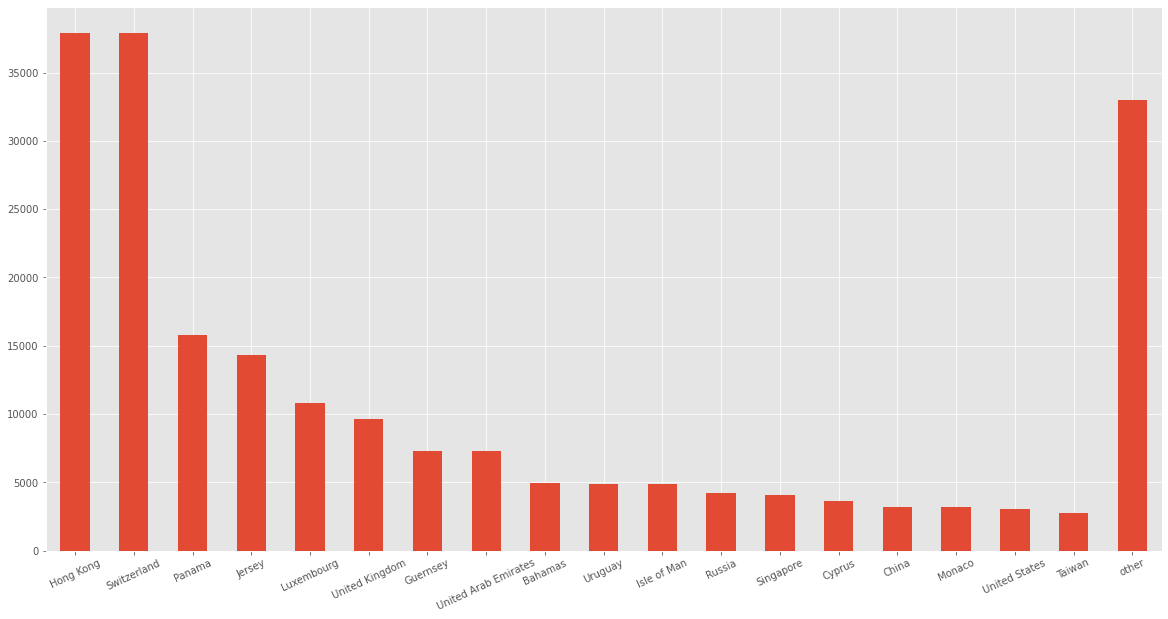

In [10]:
plt.figure(figsize=(20,10))
country_count = ents['countries'].value_counts()
threshold = 2500
mask = country_count > threshold
tail_prob = country_count.loc[~mask].sum()
country_count = country_count.loc[mask]
country_count['other'] = tail_prob
country_count.plot(kind='bar')
plt.xticks(rotation=25)
plt.show()

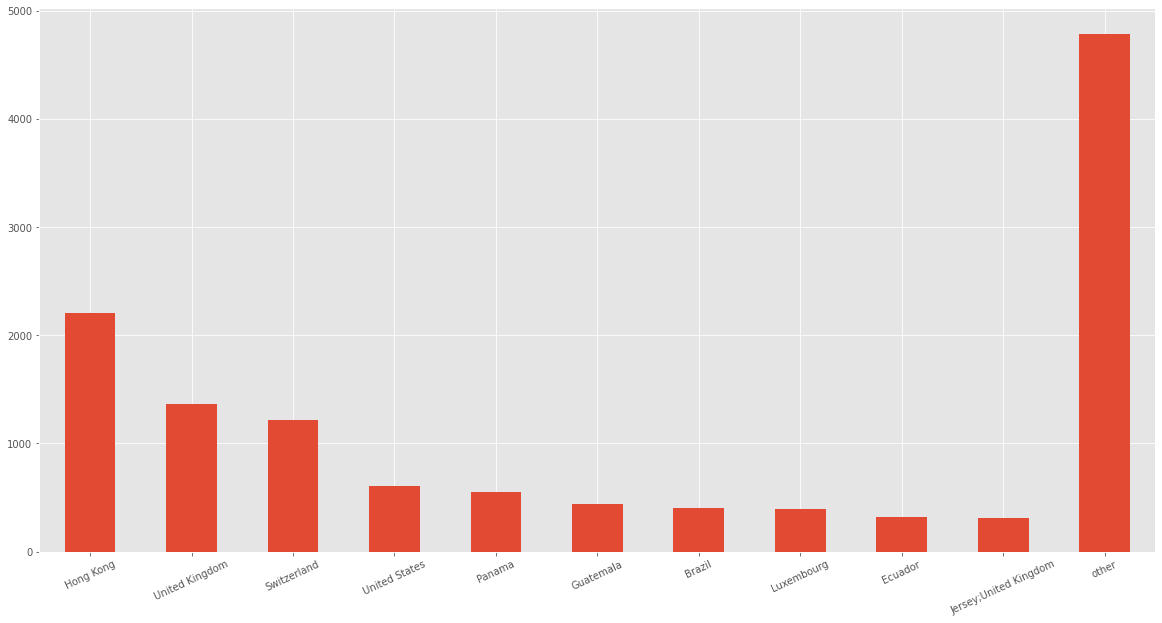

In [11]:
plt.figure(figsize=(20,10))
country_count = inter['countries'].value_counts()
threshold = 300
mask = country_count > threshold
tail_prob = country_count.loc[~mask].sum()
country_count = country_count.loc[mask]
country_count['other'] = tail_prob
country_count.plot(kind='bar')
plt.xticks(rotation=25)
plt.show()

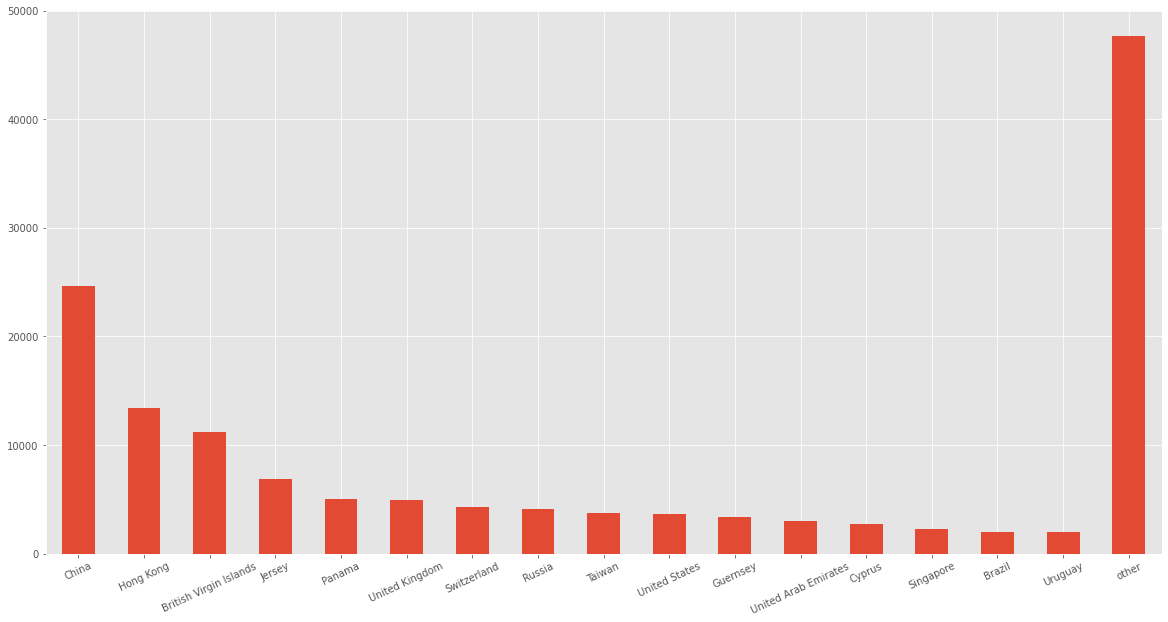

In [12]:
plt.figure(figsize=(20,10))
country_count = offi['countries'].value_counts()
threshold = 2000
mask = country_count > threshold
tail_prob = country_count.loc[~mask].sum()
country_count = country_count.loc[mask]
country_count['other'] = tail_prob
country_count.plot(kind='bar')
plt.xticks(rotation=25)
plt.show()

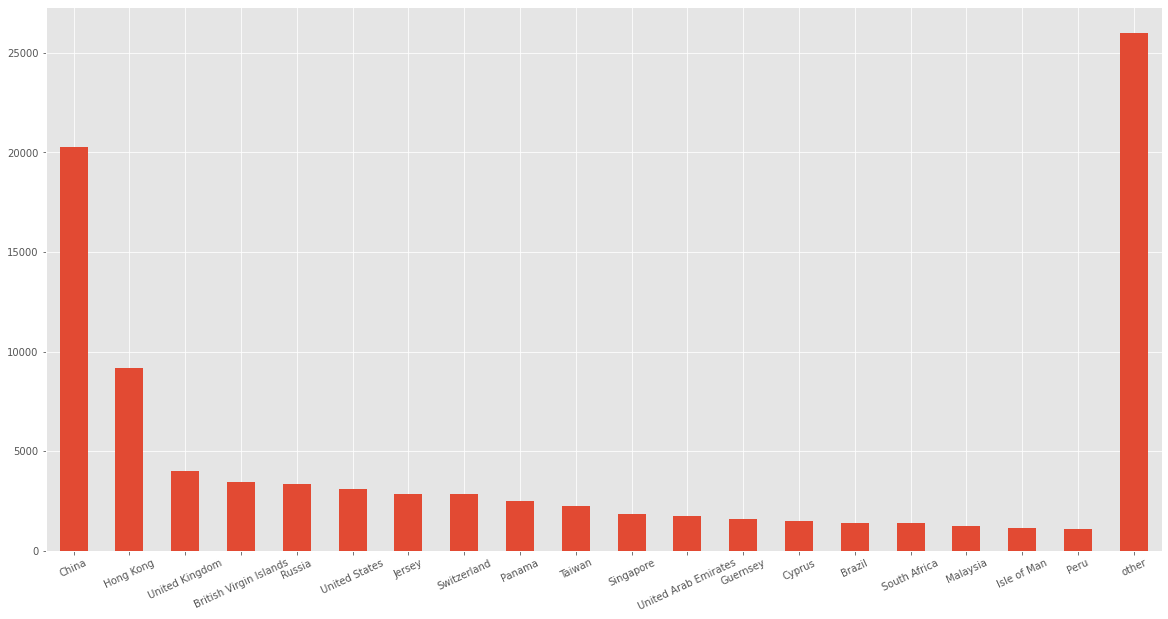

In [13]:
plt.figure(figsize=(20,10))
country_count = adds['countries'].value_counts()
threshold = 1000
mask = country_count > threshold
tail_prob = country_count.loc[~mask].sum()
country_count = country_count.loc[mask]
country_count['other'] = tail_prob
country_count.plot(kind='bar')
plt.xticks(rotation=25)
plt.show()

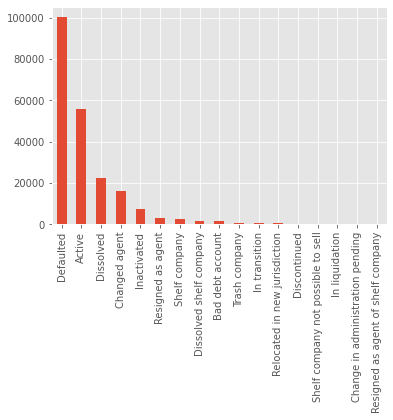

In [14]:
ents['status'].value_counts().plot(kind='bar')

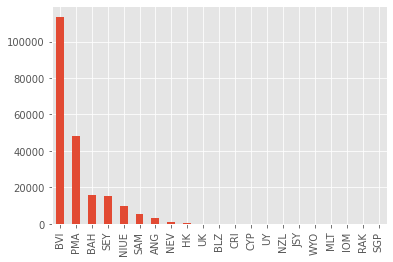

In [15]:
ents['jurisdiction'].value_counts().plot(kind='bar')

#### Defining the functions

The first thing that was done was calculating the centrality measures for all the nodes in the graph. These measures are then used to find the most important or influential nodes in the graph.

In [17]:
def compute_centrality_measures(g):
  '''
  input: graphs
  output: All possible centrality measures
  Description: Centrality measures give an idea of the importance of nodes in the system. While Gephi 
  is used for visualisation purposes, this function would be used to mathematically locate the most influential nodes
  either as entities or as officers in the system of Panama communities.
  '''

  eigenvector_centrality = nx.eigenvector_centrality(g)
  degree_centrality =   nx.degree_centrality(g)
  betweenness_centrality = nx.betweenness_centrality(g)
  pagerank = pr = nx.pagerank(g, alpha=0.9)
  closeness_centrality = nx.closeness_centrality(g)

  return eigenvector_centrality,degree_centrality,betweenness_centrality,pagerank,closeness_centrality

In [18]:
eigenvector_centrality,degree_centrality,betweenness_centrality,pagerank,closeness_centrality = compute_centrality_measures(G_FRA)

It is interesting to see the top few nodes that score high in eigenvector centrality. These nodes are important in the sense that they are connected to high scoring nodes. 

In this case, we see that Howard Kennedy Solicito is the most influential node based on its own connections and the connections of its connections. 

In [19]:
#Max eigenvalues
eigen = sorted(eigenvector_centrality.items(), key=lambda item: item[1],reverse=True)
nodes = []
print('The most influential entities/officers/intermediaries are:')
for k,v in eigen:
  nodes.append(k)
  print('{}, {}, {}'.format(k,G_FRA.nodes[k]['details']['name'],v))
  if len(nodes)==5:
    break

The most influential entities/officers/intermediaries are:
11008483, HOWARD KENNEDY SOLICITO, 0.6820754375345912
10111053, Marfleet Limited S.A., 0.20150901111628225
10074682, MAINSAIL HOLDINGS CORP., 0.18990100259611603
10144746, Palomar Holdings Limited, 0.17028260517781843
10089892, WAGNER REAL ESTATE LIMITED, 0.16191880653366075


The Eigenvector Centrality distribution is not quite surprising - most of the eigenvector centrality values are concentrated near 0, as is evident from the above scores.

It would also be interesting to spot the neighbourhood of the most important node as per eigenvector centrality

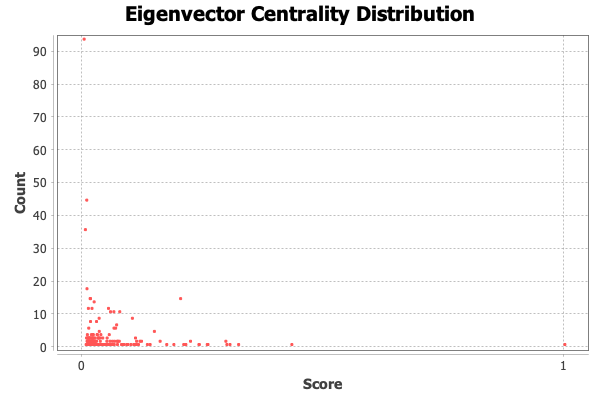

In [20]:
def neighborhood_of_ec_max_node(node,graph):
  neighbors = graph.neighbors(node)
  print()
  for neighbor in neighbors:
    print(neighbor,graph.nodes[neighbor]['details']['name'])


In [21]:
neighborhood_of_ec_max_node(eigen[0][0],G_FRA)


10208292 PETRA DEVELOPMENT S.A.
10009448 BROOCK OIL S.A.
10009449 BROADWAY HOLDINGS INC.
10005964 ZUMAYA HOLDINGS S. A.
10014941 MILLENNIUM INVESTMENTS INC.
10011476 ROSBY INTERNATIONAL LIMITED S.A.
10016154 BAYRONI MANAGEMENT SERVICES INC.
10206943 FENDERBAY LIMITED
10192608 AMULET HOLDINGS S.A.
10194963 TRISTAR SERVICES INCORPORATED
10144746 Palomar Holdings Limited
10172482 CARLTON PROPERTIES LIMITED
10169998 MADINA AL MNWORA AGENCY CORPORATION
10169982 UNICONSTRUCT INC.
10130476 SUITE HOMES INTERNATIONAL S.A.
10111053 Marfleet Limited S.A.
10089892 WAGNER REAL ESTATE LIMITED
10077162 MALABAR INVESTMENTS INC.
10077912 MARNELL INVESTMENTS LIMITED
10074682 MAINSAIL HOLDINGS CORP.
10045762 FINANCIAL MARS CORPORATION
10002297 FORDALD INC.


We see the same name again as the top connected node, Howard Kennedy Solicito.

In [22]:
#Max degree centrality
deg = sorted(degree_centrality.items(), key=lambda item: item[1],reverse=True)
nodes = []
print('The most connected entities/officers/intermediaries are:')
for k,v in deg:
  nodes.append(k)
  print('{}, {}, {}'.format(k,G_FRA.nodes[k]['details']['name'],v))
  if len(nodes)==5:
    break


The most connected entities/officers/intermediaries are:
11008483, HOWARD KENNEDY SOLICITO, 0.03475513428120063
11011495, AZUR NOMINEES LIMITED, 0.02527646129541864
10182611, MV HELEN LIMITED, 0.022116903633491312
11006577, DOORS CONSULTING LTD, 0.020537124802527645
10097260, RAYAN ASSET MANAGEMENT LTD., 0.018957345971563982


In [23]:
#Betweenness Centrality

betweenness = sorted(betweenness_centrality.items(), key=lambda item: item[1],reverse=True)
nodes = []
print('The most control over the graph is in the hands of:')
for k,v in betweenness:
  nodes.append(k)
  print('{}, {}, {}'.format(k,G_FRA.nodes[k]['details']['name'],v))
  if len(nodes)==5:
    break

The most control over the graph is in the hands of:
11008483, HOWARD KENNEDY SOLICITO, 0.004386885835982963
11011495, AZUR NOMINEES LIMITED, 0.001542284080228768
10111053, Marfleet Limited S.A., 0.001399804027436159
10074682, MAINSAIL HOLDINGS CORP., 0.0012148299238106666
11001534, CABINET HEYWOOD, 0.001149839022536845


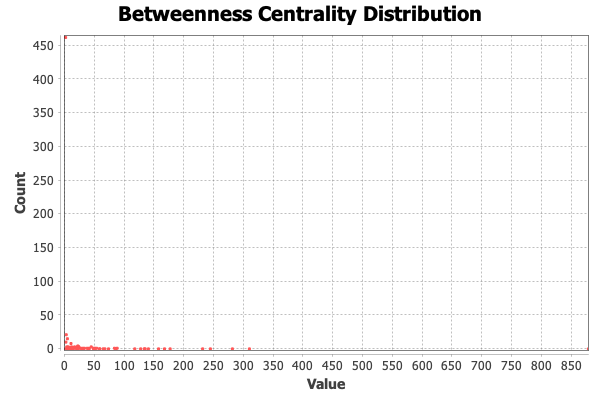

Again, we see the same names that have come up. Betweenness Centrality gives tells us that these are the trusts/firms or individuals who have the most control in the graph. This means that not only do these entities have a lot of connections with a lot of others, it also means that they have a high extent of control.

In [24]:
page = sorted(pagerank.items(), key=lambda item: item[1],reverse=True)
nodes = []
print('PageRank:')
for k,v in page:
  nodes.append(k)
  print('{}, {}, {}'.format(k,G_FRA.nodes[k]['details']['name'],v))
  if len(nodes)==5:
    break


PageRank:
11008483, HOWARD KENNEDY SOLICITO, 0.015978152091208835
11011495, AZUR NOMINEES LIMITED, 0.011711763589851166
11006577, DOORS CONSULTING LTD, 0.01029426308756493
10182611, MV HELEN LIMITED, 0.010105945187072527
10097260, RAYAN ASSET MANAGEMENT LTD., 0.009802846666205881


In [25]:
close = sorted(closeness_centrality.items(), key=lambda item: item[1],reverse=True)
nodes = []
print('The nodes closest to other nodes are:')
for k,v in close:
  nodes.append(k)
  print('{}, {}, {}'.format(k,G_FRA.nodes[k]['details']['name'],v))
  if len(nodes)==5:
    break


The nodes closest to other nodes are:
11008483, HOWARD KENNEDY SOLICITO, 0.04634017904160084
10111053, Marfleet Limited S.A., 0.03219422964995427
10074682, MAINSAIL HOLDINGS CORP., 0.03153043110047068
10144746, Palomar Holdings Limited, 0.03028170115589758
10089892, WAGNER REAL ESTATE LIMITED, 0.029693706958695686


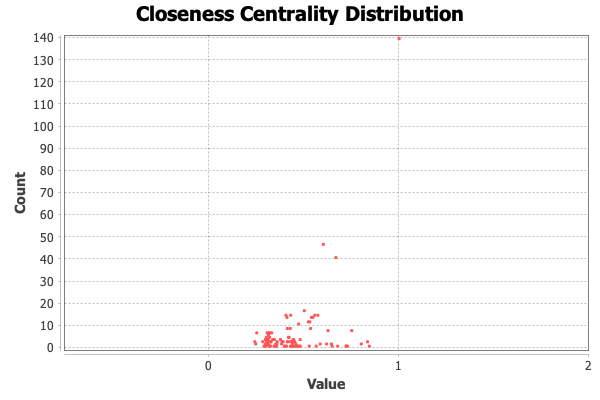



An insight generated therefore, from the above EDA, is the fact that Marfleet Limited S.A., is a node close to several other nodes, with a shortest path through it, however - it is not directly connected to many nodes.

It is deemed as one of the most influential nodes, then, due to its betweenness and closeness centrality. A lot of entities/officers/intermediaries are linked to this firm indirectly. 



In [26]:
def degree_distribution(G):
  m=3
  degree_freq = nx.degree_histogram(G)
  degrees = range(len(degree_freq))
  plt.title('Degree distribution graph for Entities and officers in France')
  plt.plot(degrees[m:], degree_freq[m:],'go-')
  plt.xlabel('Degree')
  plt.ylabel('Frequency')

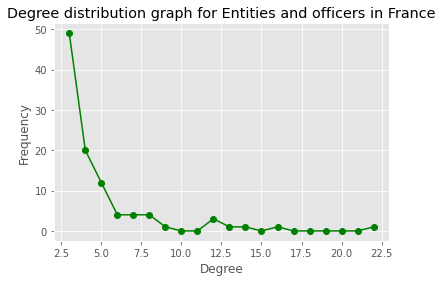

In [27]:
degree_distribution(G_FRA)

As expected, there are only very few nodes which have a high degree(hubs). These would be categorized as some of our most influential nodes in the network.

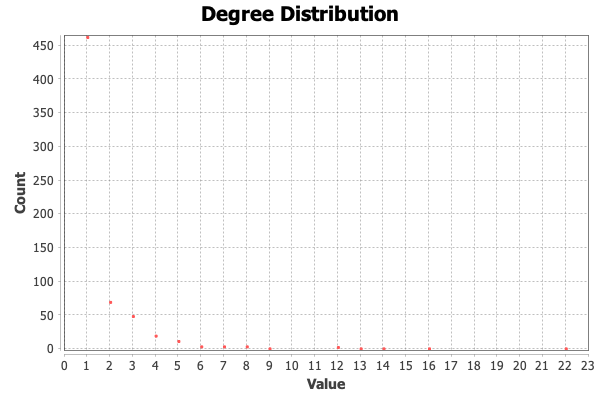

In [28]:
def top_n_most_connected_subgraph(G,n):
  '''
  input: All centrality measures as a list
  output: Top 10 most connected nodes
  Description: Finding the most connected officers/trust names
  '''
  nodes = []
  degreeView = dict(G.degree())
  sorted_degrees = sorted(degreeView.items(), key=lambda item: item[1],reverse=True)
  for k,v in sorted_degrees:
    nodes.append(k)
    print('{}, {}, {}'.format(k,G.nodes[k]['details']['name'],v))
    if len(nodes)==n:
      break


In [29]:
top_n_most_connected_subgraph(G_FRA,10)

11008483, HOWARD KENNEDY SOLICITO, 22
11011495, AZUR NOMINEES LIMITED, 16
10182611, MV HELEN LIMITED, 14
11006577, DOORS CONSULTING LTD, 13
10097260, RAYAN ASSET MANAGEMENT LTD., 12
10175339, GLOBIAN INTERNATIONAL LIMITED, 12
11001534, CABINET HEYWOOD, 12
11010989, ASCOT INTERNATIONAL MANAGEMENT SERVICES, 9
14105852, nan, 8
10111053, Marfleet Limited S.A., 8


# Ego Network

In [30]:
def create_ego_network(G):
  '''
  input: Country to split by
  Output: 
  Description: Based on the graph create an 'ego' network. Gephi, from visualisations helps in 
  creating the ego networks to show which is the most prominent one in this case.
  '''
  node_and_degree = G.degree()
  (largest_hub, degree) = sorted(node_and_degree, key=itemgetter(1))[-1]
  hub_ego = nx.ego_graph(G, largest_hub)
  pos = nx.spring_layout(hub_ego)
  labeldict = {}
  for node in hub_ego.nodes():
    labeldict[node] = G.nodes[node]['details']['name'].lower()
  nx.draw(hub_ego, pos, node_color="b", node_size=50,labels=labeldict,with_labels=True)

  options = {"node_size": 300, "node_color": "r"}
  nx.draw_networkx_nodes(hub_ego, pos, nodelist=[largest_hub], **options)
  plt.figure(figsize=(10,20))
  plt.show()

  return hub_ego

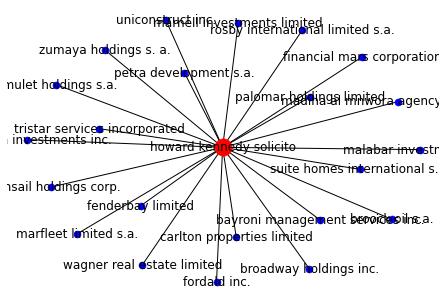

<Figure size 720x1440 with 0 Axes>

In [31]:
nx.write_gexf(create_ego_network(G_FRA),'Ego.gexf')

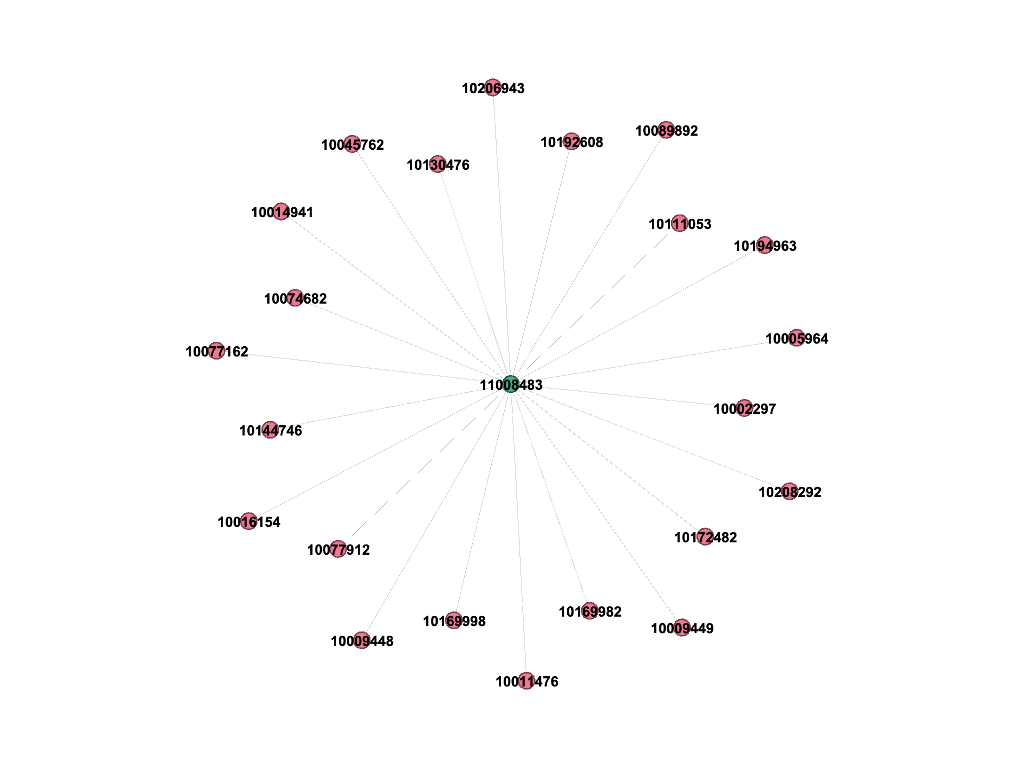

A visualisation of the ego network, which is the biggest subgraph in the given graph. What is interesting to note is that in the second graph, the one in the center is the entity, and the rest are intermediaries.

# Community detection

In [32]:
def create_community_louvain(G,cluster=8):
  '''
  input: boolean variables lovain and ledain for community detection of subgraph
  output: community visualisations,modulation coefficient
  Description: A crack at working on community detection using louvain and ledain community detection algorithms
  '''
  partition = cm.best_partition(G)
  pos = nx.spring_layout(G)
  sample = dict(filter(lambda elem: elem[1] == cluster, partition.items()))
  labeldict={}
  for node in sample.keys():
    if str(G_FRA.nodes[node]['details']['name']) != 'nan':
      labeldict[node]= G_FRA.nodes[node]['details']['name'].lower()
  nx.draw_networkx(G_FRA.subgraph(list(sample.keys())),pos,labels=labeldict,with_labels=True, node_color="b", node_size=50)
  #plt.title('Louvain for cluster {}'.format(cluster))
  #plt.show()
  print('Modularity: Louvain',cm.modularity(partition,G))

  return G_FRA.subgraph(list(sample.keys()))


Modularity: Louvain 0.9728421453956226


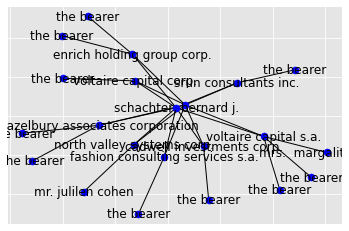

In [33]:
louvain = create_community_louvain(G_FRA)

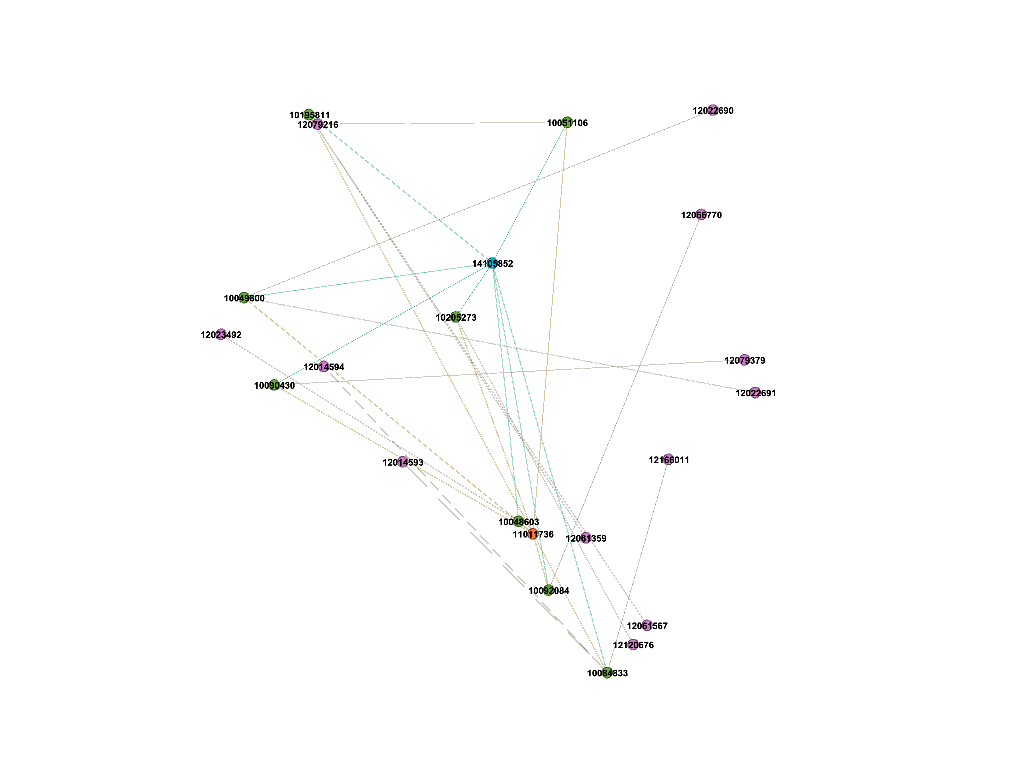

The above is a visualisation of a community created by louvain, specifically the cluster 8.

The modularity is nearly 1, indicating that the communities formed has nodes that are in fact very well related/connected within as compared to outside of the community.
In this case, it is interesting to note that the center is an address, that links the other entities/officers/intermediaries in the community. 

1. Pink - officers
2. green - entities
3. orange - intermediaries
4. blue - address

In [34]:
def create_communities_Leidan(G,cluster=8):
  '''
  input: boolean variables ledain for community detection of subgraph
  output: community visualisations,modulation coefficient
  Description: A crack at working on community detection using louvain and ledain community detection algorithms
  '''

  g = ig.Graph.from_networkx(G)
  Leiden_community = g.community_leiden(objective_function='modularity')
  graphList = Leiden_community.subgraphs()
  sample = graphList[cluster].to_networkx()
  labeldict={}
  for node in sample.nodes():
    labeldict[node]= sample.nodes[node]['details']['name']
  nx.draw_networkx(sample,labels=labeldict,with_labels=True)
  plt.title('Ledain for cluster {}'.format(cluster))
  plt.figure(figsize=(20,20))
  print('Modularity Ledain:',Leiden_community.q)

  return sample


Modularity Ledain: 0.9729119293037927


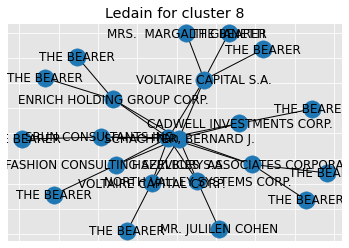

<Figure size 1440x1440 with 0 Axes>

In [35]:
nx.write_gexf(create_communities_Leidan(G_FRA,cluster=8),'ledain_created_community.gexf')

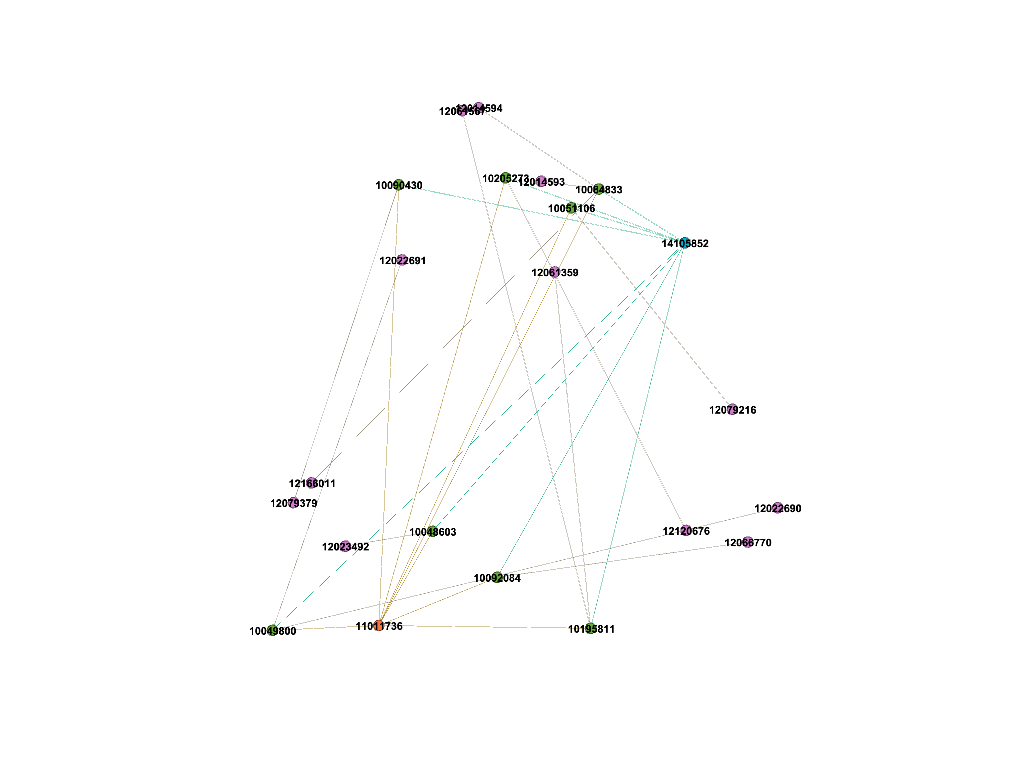

**The Ledain Algorithm**:

While the louvain algorithm is not very efficient, the ledain seems to be a promising approach for the same. The communities were created by optimisation on 'modularity'. The same can also be done by optimising the  Constant Potts Model, which might be more efficient for larger networks as it is not NP-heavy.

Our approach, however, gives us a modularity value slightly higher than the louvain algorithm. 

# K-Means Clustering

In [36]:
def k_means(X,k):
    fitted_model = KMeans(init= "k-means++", n_clusters=k,n_init=10,max_iter=300,random_state=42).fit_predict(X)
    return fitted_model

In [37]:
def create_embeddings(G):
  '''
  Description: Creating node2vec embeddings on the created subgraph.
  Output: node2vec embeddings
  '''
  node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200)
  model = node2vec.fit(window=10, min_count=1, batch_words=4)
  model.wv.save_word2vec_format('word2vec.emb')

# Save model for later use
  model.save('node2vec_model.model') 


  node_embeddings = {}
  for node in G.nodes():
    node_embeddings[node] = model.wv[str(node)]

  df_embeddings = pd.DataFrame.from_dict(node_embeddings)

  return df_embeddings.T,node_embeddings,model


In [38]:
df_embeddings,node_embeddings,model = create_embeddings(G_FRA)

Generating walks (CPU: 1):   0%|          | 0/200 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 200/200 [02:06<00:00,  1.59it/s]


In [39]:
def clustering(df_embeddings,k):
  '''
  Description: Perform clustering of the connected nodes
  '''
  sscores = {}
  for k in tqdm(range(2,k)):
    clusters = k_means(df_embeddings.values,k)
    sscores[k] = silhouette_score(df_embeddings.values, clusters)

  max_value = max(sscores.values())
  max_keys = [k for k, v in sscores.items() if v == max_value]

  print('max silhouette score is {} for cluster {}'.format(max_value,max_keys))
  clusters = k_means(df_embeddings,max_keys[0])
  df_embeddings['cluster'] = clusters
  return max_keys, df_embeddings

In [40]:
max_keys,df_embeddings = clustering(df_embeddings,200)

100%|██████████| 198/198 [02:42<00:00,  1.22it/s]


max silhouette score is 0.7197875380516052 for cluster [160]


Node2Vec embedding technique was used to generate embeddings of the nodes and edges of the graph. This means that the graph is now translated to a lower dimension and can now be used as vectors!

It can be interesting to use these vectors for finding communities, perhaps through k-means clustering. The Silhouette score is not as good as the modularity guaranteed by the ledain method, which means that while the embeddings are capturing most of the essence of the relationships, they are not quite complete for forming clusters.

However, we can proceed for performing a link prediction with this data to see if our machine learning model can guess the relationships held between nodes given a training set. In other words, the application could be to find potential links between two nodes, for which a current paper trail does not exist, based on the characteristics of the two entities/intermediaries/officers/addresses being examined.

In [44]:
def plot_community(df,cluster,G):
  df_cluster = df[df['cluster']==cluster]
  G_cluster = G.subgraph(df_cluster.index)
  labeldict = {}
  for node in G_cluster.nodes():
    labeldict[node] = G_cluster.nodes[node]['details']['name'].lower()
  print(labeldict)
  nx.draw(G_cluster,with_labels=True,labels=labeldict,)
  plt.title('graph of the cluster')

  return G_cluster

{10092645: 'kromberg holdings limited', 10122695: 'online consultants holdings limited', 10203144: 'elysmail limited', 10094697: 'chandler global limited', 10104077: 'oryx enterprises limited', 10101078: 'geotechnique limited', 11001534: 'cabinet heywood'}


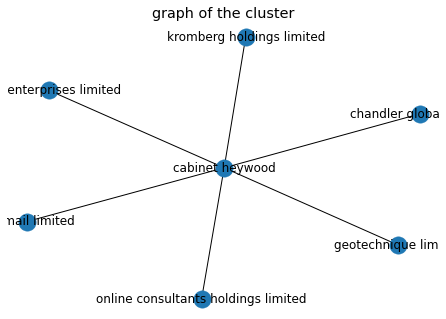

In [45]:
nx.write_gexf(plot_community(df_embeddings,7,G_FRA),'kmeanscluster.gexf')

# Link Prediction

In [46]:
def link_prediction(model,edges_FRA,graph):
  '''
  input: node2vec model, graph,edge list
  Output: ROC AUC score of the model predicting the links
  Description: Perform link prediction to see a possibility of a connection between two nodes
  '''
  all_links = edges_FRA[['START_ID','END_ID']]
  link_list = list(zip(edges_FRA.START_ID, edges_FRA.END_ID))
  H_FRA = graph.to_undirected()
  node_list = list(set(all_links['START_ID'].tolist() + all_links['END_ID'].tolist()))
  # build adjacency matrix
  adj_G = nx.to_numpy_matrix(H_FRA, nodelist = node_list)
  all_unconnected_pairs = []

# traverse adjacency matrix
  offset = 0
  for i in tqdm(range(adj_G.shape[0])):
    for j in range(offset,adj_G.shape[1]):
      if i != j and nx.has_path(H_FRA,node_list[i], node_list[j]) :
        if nx.shortest_path_length(H_FRA, node_list[i], node_list[j])<=2:
          if adj_G[i,j] == 0:
            all_unconnected_pairs.append([node_list[i],node_list[j]])

    offset = offset + 1

  node_1_unlinked = [i[0] for i in all_unconnected_pairs]
  node_2_unlinked = [i[1] for i in all_unconnected_pairs]

  data = pd.DataFrame({'START_ID':node_1_unlinked, 
                     'END_ID':node_2_unlinked})

  # add target variable 'link'
  data['link'] = 0

  initial_node_count = len(H_FRA.nodes)

  all_links_temp = all_links.copy()

# empty list to store removable links
  omissible_links_index = []

  for i in tqdm(all_links.index.values):
  
  # remove a node pair and build a new graph
    G_temp = nx.from_pandas_edgelist(all_links_temp.drop(index = i), "START_ID", "END_ID", create_using=nx.Graph())
  # check there is no spliting of graph and number of nodes is same
    if (nx.number_connected_components(G_temp) == nx.number_connected_components(H_FRA)) and (len(G_temp.nodes) == initial_node_count):
      omissible_links_index.append(i)
      all_links_temp = all_links_temp.drop(index = i)


  all_links_ghost = all_links.loc[omissible_links_index]

  # add the target variable 'link'
  all_links_ghost['link'] = 1

  data = data.append(all_links_ghost[['START_ID', 'END_ID', 'link']], ignore_index=True)
  # drop removable edges
  all_links_partial = all_links.drop(index=all_links_ghost.index.values)

  # build graph
  G_data = nx.from_pandas_edgelist(all_links_partial, "START_ID", "END_ID", create_using=nx.Graph())

  x = [(model[str(i)]+model[str(j)]) for i,j in zip(data['START_ID'], data['END_ID'])]

  xtrain, xtest, ytrain, ytest = train_test_split(np.array(x), data['link'], 
                                                test_size = 0.3, 
                                                random_state = 35)
  lr = sklearn.linear_model.LogisticRegression(class_weight="unbalanced")

  lr.fit(xtrain, ytrain)
  predictions = lr.predict_proba(xtest)
  preds = lr.predict(xtest)
  print(" \n ")
  print('The logistic regression model performance for link prediction is {}'.format(roc_auc_score(ytest, predictions[:,1])))


In [47]:
link_prediction(model,edges_FRA,G_FRA)

100%|██████████| 556/556 [00:01<00:00, 302.19it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


 
 
The logistic regression model performance for link prediction is 0.8053486797562627


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


The link prediction has an ROC-AUC of 0.86. However, this result is non conclusive as only a very small subgraph has been chosen for the experiment. Perhaps with a larger graph, the results would be tangible.